In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)


from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *
from encoding_information.information_estimation import estimate_mutual_information



2024-01-13 12:35:27.540320: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-13 12:35:28.208007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

## Optimize the convolution matrix to map a delta towards a target signal

  0%|          | 0/1 [00:00<?, ?it/s]

initial loss 0.06022940855063564


100%|██████████| 1/1 [00:19<00:00, 19.39s/it]


Array(1., dtype=float64)

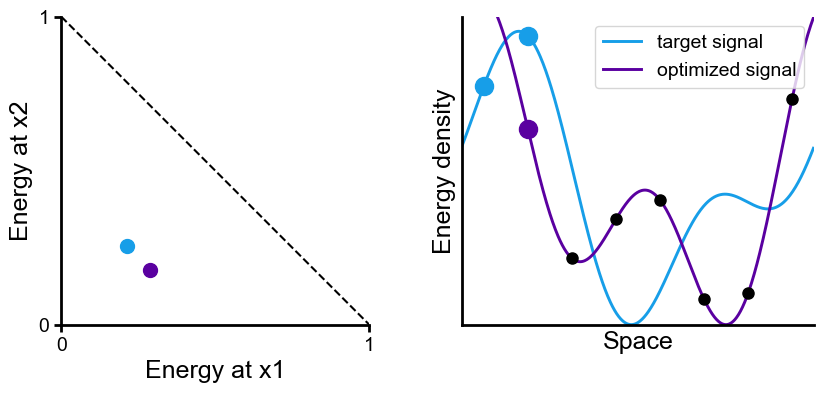

In [2]:
use_sampling_indices = False
sampling_indices = (0, 1)
unit_energy = True
num_nyquist_samples = 4

delta_function = generate_random_object('delta')

target_signal = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=unit_energy)
initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True)

optimized_kernels, output_signals, optimized_params = optimize_towards_target_signals(
    [integrate_pixels(target_signal, num_nyquist_samples=num_nyquist_samples)], delta_function, initial_kernel, sampling_indices=sampling_indices if use_sampling_indices else None, verbose=True, return_params=True)
optimized_kernel = optimized_kernels[0]

initial_signal = make_convolutional_encoder(initial_kernel) @ delta_function
optimized_signal = make_convolutional_encoder(optimized_kernel) @ delta_function

# plot target and optimized signal in intensity and spatial coordinates
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_in_intensity_coordinates(ax[0], target_signal, label='target signal', sampling_indices=sampling_indices, num_nyquist_samples=num_nyquist_samples)
plot_in_intensity_coordinates(ax[0], optimized_signal, label='optimized signal', sampling_indices=sampling_indices, num_nyquist_samples=num_nyquist_samples)

plot_in_spatial_coordinates(ax[1], target_signal, label='target signal', sampling_indices=sampling_indices)
plot_in_spatial_coordinates(ax[1], optimized_signal, label='optimized signal', sampling_indices=sampling_indices, show_samples=True)
ax[1].legend()

optimized_signal.sum()

## Plot uniformly random signals

Generating signals:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating signals: 1008it [00:13, 76.61it/s]                          


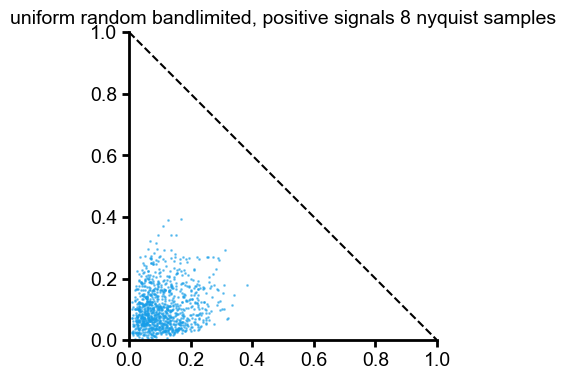

In [2]:
num_nyquist_samples = 8
num_signals = 1000
sampling_indices = (0, 1)

signals = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, num_signals=num_signals)
# signals = np.roll(signals, 64, axis=1)
integrated_signals = integrate_pixels(signals, num_nyquist_samples=num_nyquist_samples)

x1, x2 = integrated_signals[:, sampling_indices[0]], integrated_signals[:, sampling_indices[1]]
# now scatter only the positive targets
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x1, x2, s=1, alpha=0.5)
# plot dashed line for the L1 ball
ax.plot(np.linspace(0, 1, 100), 1 - np.abs(np.linspace(0, 1, 100)), '--', color='k')
# square axes
ax.set_aspect('equal', 'box')
clear_spines(ax)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.title.set_text('uniform random bandlimited, positive signals {} nyquist samples'.format(num_nyquist_samples))

## Compare entropy to uniform entropy

In [14]:
def compute_mutual_information_for_optimized_encoder(num_objects, num_nyquist_samples, noise_sigma, key,
                                                     upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH):
    
    objects_fn = lambda : np.array([generate_random_object('delta', object_size=upsampled_signal_length)
                                     for i in range(num_objects)])

    initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True, upsampled_signal_length=upsampled_signal_length)
    initial_params = params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)
    loss_fn = make_convolutional_forward_model_with_mi_loss(objects_fn(), noise_sigma, num_nyquist_samples=num_nyquist_samples, 
                                                            upsampled_signal_length=upsampled_signal_length)
    optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                            initial_params,
                              learning_rate=1e-2, learning_rate_decay=0.999,
                              verbose=True,
                            loss_improvement_patience=2000, max_epochs=3000, key=key)

    output_signals = conv_forward_model(optimized_params, objects_fn(), num_nyquist_samples=num_nyquist_samples, integrate_output_signals=True, 
                                        upsampled_signal_length=upsampled_signal_length)
    key, subkey = jax.random.split(key)
    noisy_signals = output_signals + noise_sigma * jax.random.normal(subkey, output_signals.shape)

    scale_factor = 1000 # becayse here its 0-1 range
    fake_images = noisy_signals.reshape(-1, int(np.sqrt(num_nyquist_samples)), int(np.sqrt(num_nyquist_samples))) * scale_factor
    mi = estimate_mutual_information(fake_images, gaussian_noise_sigma=noise_sigma*scale_factor, entropy_model='pixelcnn', verbose=False)
    # mi = compute_mutual_information_per_pixel(noisy_output_signals=noisy_output_signals, noise_sigma=noise_sigma,)
    return mi, subkey

def compute_uniform_samples_mi(num_signals, num_nyquist_samples, noise_sigma, key, upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH):
    uniformly_sampled_signals = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, 
                                                                            num_signals=num_signals, upsampled_signal_length=upsampled_signal_length)

    signals = integrate_pixels(uniformly_sampled_signals, num_nyquist_samples=num_nyquist_samples)

    noisy_signals = signals + noise_sigma * jax.random.normal(key, signals.shape)

    scale_factor = 1000 # becayse here its 0-1 range
    fake_images = noisy_signals.reshape(-1, int(np.sqrt(num_nyquist_samples)), int(np.sqrt(num_nyquist_samples))) * scale_factor
    mi = estimate_mutual_information(fake_images, gaussian_noise_sigma=noise_sigma*scale_factor, entropy_model='pixelcnn', verbose=False)

    # uniform_mi = compute_mutual_information_per_pixel(noisy_output_signals=noisy_signals, noise_sigma=noise_sigma,)
    return mi


In [38]:
num_nyquist_samples_list = [4, 9, 16, 25]
key = jax.random.PRNGKey(0)
noise_sigma = 1e-3
num_objects = 8000
num_replicates = 3

mi_list = []
mi_uniform_list = []
for num_nyquist_samples in tqdm(num_nyquist_samples_list):
    mi_list.append([])
    mi_uniform_list.append([])
    for i in tqdm(range(num_replicates)):
        
        upsampled_signal_length = num_nyquist_samples * 32
        mi, key = compute_mutual_information_for_optimized_encoder(num_objects, num_nyquist_samples, noise_sigma, key,          
                                                                upsampled_signal_length=upsampled_signal_length)
        mi_list[-1].append(mi)

        _, key = jax.random.split(key)
        mi_uniform = compute_uniform_samples_mi(num_objects, num_nyquist_samples, noise_sigma, key, 
                                                upsampled_signal_length=upsampled_signal_length)
        _, key = jax.random.split(key)
        mi_uniform_list[-1].append(mi_uniform)


  0%|          | 0/1 [00:00<?, ?it/s]


IndexError: index -2 is out of bounds for axis 0 with size 0

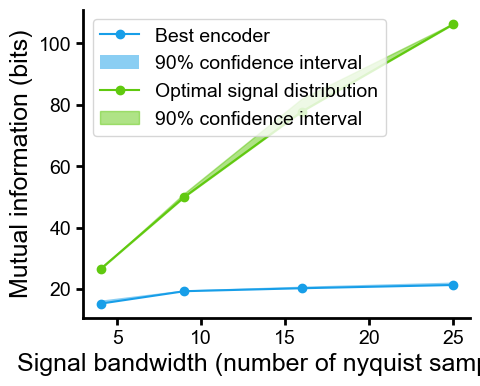

In [26]:
confidence = 90

# compute total mi rather than pixel wise
num_nyquist_samples_list = np.array(num_nyquist_samples_list)
mi_estimates = np.array(mi_list) * num_nyquist_samples_list[:, None]
mi_uniform_estimates = np.array(mi_uniform_list) * num_nyquist_samples_list[:, None]

mi_estimates_lower = onp.min(mi_estimates, axis=1)
mi_uniform_estimates_lower = onp.min(mi_uniform_estimates, axis=1)

mi_estimates_upper = onp.percentile(mi_estimates, confidence, axis=1)
mi_uniform_estimates_upper = onp.percentile(mi_uniform_estimates, confidence, axis=1)



# plot toal mi
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(num_nyquist_samples_list, mi_estimates_lower, '-o', label='Best encoder')
ax.fill_between(num_nyquist_samples_list, mi_estimates_lower, mi_estimates_upper, alpha=0.5, label=f'{confidence}% confidence interval')

ax.plot(num_nyquist_samples_list, mi_uniform_estimates_lower, '-o', label='Optimal signal distribution', color=get_color_cycle()[3])
ax.fill_between(num_nyquist_samples_list, mi_uniform_estimates_lower, mi_uniform_estimates_upper, alpha=0.5, label=f'{confidence}% confidence interval', color=get_color_cycle()[3])

ax.set(xlabel='Signal bandwidth (number of nyquist samples) ', ylabel='Mutual information (bits)')
clear_spines(ax)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'actual_vs_optimal_mi' + '.pdf', transparent=True)

## Make plots of optimal and actual distributions

In [2]:
# generate the signals

def compute_best_encoded_signals(num_objects, num_nyquist_samples, noise_sigma, key,
                                                     upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH):
    
    objects_fn = lambda : np.array([generate_random_object('delta', object_size=upsampled_signal_length)
                                     for i in range(num_objects)])

    initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True, upsampled_signal_length=upsampled_signal_length)
    initial_params = params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)
    loss_fn = make_convolutional_forward_model_with_mi_loss(objects_fn(), noise_sigma, num_nyquist_samples=num_nyquist_samples, 
                                                            upsampled_signal_length=upsampled_signal_length)
    optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                            initial_params,
                              learning_rate=1e-2, learning_rate_decay=0.999,
                              verbose=True,
                            loss_improvement_patience=1000, max_epochs=1000, key=key)

    output_signals = conv_forward_model(optimized_params, objects_fn(), num_nyquist_samples=num_nyquist_samples, integrate_output_signals=False, 
                                        upsampled_signal_length=upsampled_signal_length)
    return key, output_signals

key = jax.random.PRNGKey(0)
noise_sigma = 1e-3
num_objects = 50000

num_nyquist_samples = 4
upsampled_signal_length = num_nyquist_samples * 256

key, signals_encoded = compute_best_encoded_signals(num_objects, num_nyquist_samples, noise_sigma, key,          
                                                        upsampled_signal_length=upsampled_signal_length)
signals_uniform = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, num_signals=num_objects,upsampled_signal_length=upsampled_signal_length)

initial loss -5.287304107197479


Generating signals: 50005it [00:53, 943.45it/s]                            


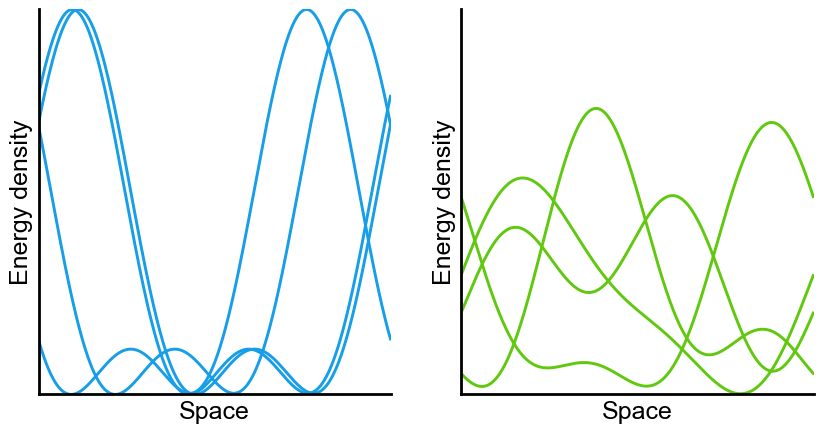

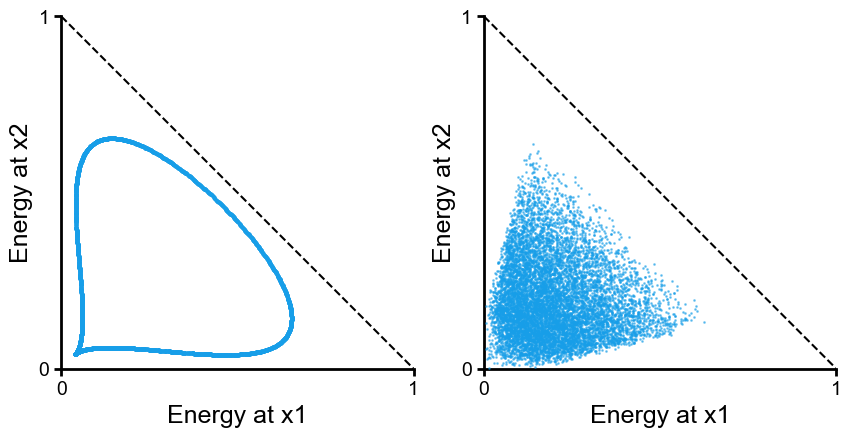

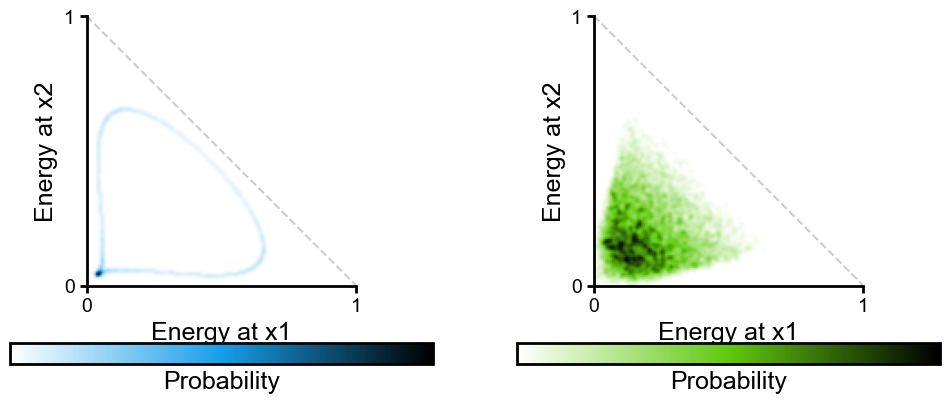

In [45]:
# Make plots
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ymax = max(onp.max(signals_encoded), onp.max(signals_uniform))
plot_in_spatial_coordinates(ax[0], signals_encoded[:4], num_nyquist_samples=num_nyquist_samples, ymax=ymax, color=get_color_cycle()[0])
plot_in_spatial_coordinates(ax[1], signals_uniform[:4], num_nyquist_samples=num_nyquist_samples, ymax=ymax, color=get_color_cycle()[3])
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_example_signals_{num_nyquist_samples}_nyquist' + '.pdf', transparent=True)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_intensity_coordinates(ax[0], signals_encoded, num_nyquist_samples=num_nyquist_samples, s=3, alpha=0.5,)
plot_in_intensity_coordinates(ax[1], signals_uniform, num_nyquist_samples=num_nyquist_samples, s=1, alpha=0.5,)


def plot_distribution(ax, x, y, cmap):

    # bin into 2d histogram
    num_bins = 150
    sigma_smooth = 1
    xx, yy = np.meshgrid(np.linspace(0, 1, num_bins), np.linspace(0, 1, num_bins))
    hist, xedges, yedges = np.histogram2d(x, y, bins=[xx[0], yy[:, 0]])
    hist = hist.astype(np.float32)
    hist = gaussian_filter(hist, sigma=sigma_smooth)
    hist /= hist.sum()
    im = ax.imshow(hist.T, origin='lower', extent=[0, 1, 0, 1], cmap=cmap)
    # plot the dotted line from [1, 0] to [0, 1]
    ax.plot([0, 1], [1, 0], '--', color='k', alpha=0.2)
    # add a colorbar to this axis
    colorbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15)
    colorbar.set_label('Probability')
    colorbar.set_ticks([])  # Hides the ticks
    clear_spines(ax)
    ax.set(yticks=[0, 1], xticks=[0, 1], xlabel='Energy at x1', ylabel='Energy at x2')



fig, ax = plt.subplots(1, 2, figsize=(12, 5))
encoded_integrated = integrate_pixels(signals_encoded, num_nyquist_samples=num_nyquist_samples)
uniform_integrated = integrate_pixels(signals_uniform, num_nyquist_samples=num_nyquist_samples)

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", get_color_cycle()[0], 'black'])
plot_distribution(ax[0], encoded_integrated[:, 0], encoded_integrated[:, 1], cmap)
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", get_color_cycle()[3], 'black'])
plot_distribution(ax[1], uniform_integrated[:, 0], uniform_integrated[:, 1], cmap)

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_distribution_{num_nyquist_samples}_nyquist' + '.pdf', transparent=True)